<img src="https://lies.mat.uc.cl/wp-content/uploads/2017/09/logo-uc-lineal-azul.png" width="200px" alt="puc logo">
<hr>
<h2 align="center"> A Bayesian Approach to select machine learning models in astronomy  </h2>
<h3 align="left"> Francisco Pérez Galarce </h3>
<h3 align="left"> Advisor: Karim Pichara</h3>
<h3 align="left"> Doctorado en Ciencias de la Ingeniería </h3>
<hr>



*Abstract*: 

In many scientific disciplines and practitioner contexts, the selection of the best mathematical model to represent a real phenomenon is a relevant problem. Typically, two main criteria are considered, the goodness of fit and the model complexity. In the machine learning field, the most common strategies for model comparison are related to cross-validation. These techniques have two important drawbacks, they do not embody the principle of parsimony (also known as Occam's razor principle) and their performance decrease when the sample size is smaller. One way to tackle these limitations is through Bayesian statistic that offers a direct way to compare models through the marginal likelihood function. This function associates the parsimony principle and the goodness of fit. However, this approach has two relevant challenges: (i) the function estimation is very complex when it is worked with high dimensional data and (ii) we must model the phenomenon as a Bayesian model, what sometimes it requires a deep understanding of the Bayesian statistic theory. 

In this research project, it is proposed to apply the marginal likelihood function in the comparison of machine learning models in astronomy. Additionally, the performance of this approach will be compared with traditional methods based on cross-validation. In this talk, will be presented experiments comparing these approaches in basic classification methods in a database of variable stars. 
    

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
import  sklearn.linear_model as linearModel
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
import numpy as np
import seaborn 
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
import timeit
import pymc3 as pm
import matplotlib.lines as mlines
from sklearn import svm

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import bridgeSampling as bs # it contains a method to estimate the marginal likelihood according to the Bridge Sampling approach
import utilFunctions as ut          # it has different methods to handle and plot data 
import BayesianModels as bm # it has methods to build and train bayesian model (Logistic Regression and Neural Nets) 
import experiments as exp  

In [3]:
VVV = ut.readFileFats('FATS_MACHO_lukas.dat', sepColumns=' ', sepHeader= ' ')
VVV.head()

,ID,N,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,SlottedA_length,StetsonK_AC,Con,...,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_rel_phase_0,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3
0,lc_25.3469.117.R,376,0.16899991,0.32679528,0.72498505,-0.01485156,28.00000000,54.24218750,0.76094731,0.00278552,...,-1.46059122,0.38494602,0.00000000,0.45064598,0.61319308,1.98092073,0.00000000,2.63458742,1.19809472,-0.17911086\n
1,lc_5.4643.149.R,1006,0.22049999,0.29251415,0.73686463,-0.01638369,48.00000000,5.48437500,0.69519776,0.02156057,...,0.29463824,-2.38874819,0.00000000,0.76794739,-0.33559748,-0.37525168,0.00000000,-2.44012556,-2.78237280,-2.04775632\n
2,lc_64.8088.215.B,269,0.27600002,0.32271340,0.72082220,-0.02510585,16.00000000,1.87109375,0.73968096,0.00389105,...,2.36559368,1.80869263,0.00000000,-1.62348227,-1.06673508,-1.70429012,0.00000000,0.59470484,-0.14292905,-0.58894841\n
3,lc_211.16703.311.R,921,0.33349991,0.16151997,0.72011310,-0.02752819,1.00000000,0.89843750,0.61165855,0.00000000,...,-0.04237501,-0.26331226,0.00000000,-1.22177429,-2.98334018,-0.22196910,0.00000000,2.01649332,1.37355219,0.77553279\n
4,lc_9.4882.332.B,1096,0.32900000,0.35265988,0.77369223,-0.03572465,153.00000000,192.53906250,0.77325378,0.00000000,...,1.99455615,1.36360846,0.00000000,-0.72691122,-1.95857367,0.14543090,0.00000000,-2.65217842,0.30175383,-1.14339972\n


In [4]:
VVV.columns

Index(['ID', 'N', 'Amplitude', 'Rcs', 'StetsonK', 'Meanvariance',
       'Autocor_length', 'SlottedA_length', 'StetsonK_AC', 'Con', 'Beyond1Std',
       'SmallKurtosis', 'Std', 'Skew', 'MaxSlope', 'MedianAbsDev', 'MedianBRP',
       'PairSlopeTrend', 'FluxPercentileRatioMid20',
       'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50',
       'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80',
       'PercentDifferenceFluxPercentile', 'PercentAmplitude', 'LinearTrend',
       'Eta_e', 'Mean', 'Q31', 'AndersonDarling', 'PeriodLS', 'Period_fit',
       'Psi_CS', 'Psi_eta', 'CAR_sigma', 'CAR_tau', 'CAR_mean',
       'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1',
       'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1',
       'Freq3_harmonics_amplitude

In [5]:
VVV = ut.readFileFats('FATS_MACHO_lukas2.dat', sepColumns=' ', sepHeader= ' ')


0       0.00000000
1       0.00000000
2       0.00000000
3       0.00000000
4       0.00000000
5       0.00000000
6       0.00000000
7       0.00000000
8       0.00000000
9       0.00000000
10      0.00000000
11      0.00000000
12      0.00000000
13      0.00000000
14      0.00000000
15      0.00000000
16      0.35262600
17      0.00000000
18      0.00000000
19      0.00000000
20      0.00000000
21      0.00000000
22      0.00000000
23      0.00000000
24      0.00000000
25      0.00000000
26      0.00000000
27      0.00000000
28      0.00000000
29      0.00234072
           ...    
4166    0.00000000
4167    0.00000000
4168    0.00000000
4169    0.00000000
4170    0.00000000
4171    0.00000000
4172    0.00000000
4173    0.00000000
4174    0.00000000
4175    0.00000000
4176    0.00012672
4177    0.00000000
4178    0.00000000
4179    0.00000000
4180    0.00000000
4181    0.00000000
4182    0.00000000
4183    0.00000000
4184    0.00000000
4185    0.00258813
4186    0.00000000
4187    0.00

In [3]:
OGLE = ut.readFileFats('OGLE.csv', formatFile='.csv')
OGLE.describe()

,Psi_eta,PercentAmplitude,MaxSlope,SmallKurtosis,StetsonK,Meanvariance,Rcs,FluxPercentileRatioMid65,Freq3_harmonics_amplitude_0,Freq3_harmonics_amplitude_1,...,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,PairSlopeTrend,CAR_sigma,Autocor_length,MedianAbsDev,SlottedA_length,FluxPercentileRatioMid80,PeriodLS,StetsonK_AC
count,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,...,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000,5297.000000
mean,0.870032,0.028789,12.188757,2.358079,0.799762,0.007353,0.073724,0.604951,0.026810,0.007548,...,0.034863,0.034790,-0.004990,-0.173880,2.226543,0.085994,3.103226,0.799859,118.282651,0.761247
std,0.711650,0.030100,45.189672,14.141616,0.074849,0.005349,0.049965,0.123517,0.026688,0.010984,...,1.259794,1.268530,0.132622,0.685651,3.869963,0.062331,7.991584,0.093330,606.798761,0.122444
min,0.003002,0.001324,0.008856,-1.667985,0.355422,0.000407,0.015901,0.080702,0.001292,0.000021,...,-3.048792,-3.130272,-0.700000,-7.342662,1.000000,0.003000,0.972420,0.137681,0.059134,0.293252
25%,0.146659,0.010386,0.583516,-0.929845,0.759576,0.003687,0.041551,0.530928,0.009069,0.001591,...,-0.868714,-0.844738,-0.100000,-0.317462,1.000000,0.037500,0.972420,0.750000,0.445529,0.662756
50%,0.720800,0.019995,2.232487,-0.115934,0.806637,0.006654,0.056490,0.590909,0.019509,0.003968,...,0.046689,0.023903,-0.033333,-0.100079,1.000000,0.082000,0.972420,0.799392,1.032325,0.797274
75%,1.604855,0.033579,8.446771,1.772086,0.855277,0.010143,0.084387,0.684659,0.035091,0.009155,...,0.919533,0.932886,0.100000,-0.001934,1.000000,0.124000,1.944840,0.866667,4.273561,0.869131
max,2.181096,0.239290,999.712643,328.583729,0.943910,0.068965,0.334666,0.929412,0.427434,0.198837,...,3.019060,3.106257,0.766667,6.605224,40.000000,0.849500,159.476880,0.974101,16980.892140,0.966310


In [4]:
OGLE_train, OGLE_test, OGLE_label_train, OGLE_label_test = ut.Define_TrainSet(OGLE, id_col= 'ogle_id', plot= False, test=0.2, name_class_col= 'class_name')

train = ut.preprocess(OGLE_train, delete_correlation= False, delete_noVariation= False, delete_outlier= False)
test = ut.preprocess(OGLE_train, delete_correlation= False, delete_noVariation= False, delete_outlier= False)

OGLE_train = train.replace('\n', '', regex = True).replace('null', '0.0', regex = True).apply(pd.to_numeric, errors ='ignore')
OGLE_test = test.replace('\n', '', regex = True).replace('null', '0.0', regex = True).apply(pd.to_numeric, errors ='ignore')

In [5]:
OGLE_train.shape

(4237, 60)

In [9]:
VVV = ut.readFileFats('FATS_VVV.dat', sepColumns=',', sepHeader= ' ')
VVV.describe()

,ID,Class,N,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,SlottedA_length,StetsonK_AC,...,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_rel_phase_0,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3
count,192458,192458,192458,192458,192458,192458,192458,192458,192458,192458,...,192458,192458,192458,192458,192458,192458,192458,192458,192458,192458
unique,192458,6,153,162184,137675,10,1378,192143,121019,120951,...,190067,192311,163747,190703,192078,665,192403,191032,191403,191472
top,515448113003,VVV_v3_NC,50,0.16693401,1.00000000,1.00000000,0.33333333,28.01626478,0.00007910,0.59450248,...,0.21196111,1.67531174,0.12439728,0.16091907,0.61023259,0.97265625,-0.05843681,0.09975880,0.79242272,1.00000000\n
freq,1,128310,14276,6,28108,188819,6391,3,27677,27677,...,3,2,7,3,2,7617,2,3,3,208


In [10]:
vvv_train, vvv_test, vvv_label_train, vvv_label_test = ut.Define_TrainSet(VVV, id_col= 'ID', plot= False, test=0.98, name_class_col= 'Class')
del vvv_train['class_name']
del vvv_test['class_name']
train = ut.preprocess(vvv_train, delete_correlation= False, delete_noVariation= False, delete_outlier= False)
vvv_train = train.replace('\n', '', regex = True).replace('null', '0.0', regex = True).apply(pd.to_numeric, errors ='ignore')

tesp = ut.preprocess(vvv_test, delete_correlation= False, delete_noVariation= False, delete_outlier= False)
vvv_train = test.replace('\n', '', regex = True).replace('null', '0.0', regex = True).apply(pd.to_numeric, errors ='ignore')

# Dataset inspection and visualization

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 2647 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2648
[t-SNE] Computed conditional probabilities for sample 2000 / 2648
[t-SNE] Computed conditional probabilities for sample 2648 / 2648
[t-SNE] Mean sigma: 0.380225
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.047281
[t-SNE] Error after 100 iterations: 0.047281


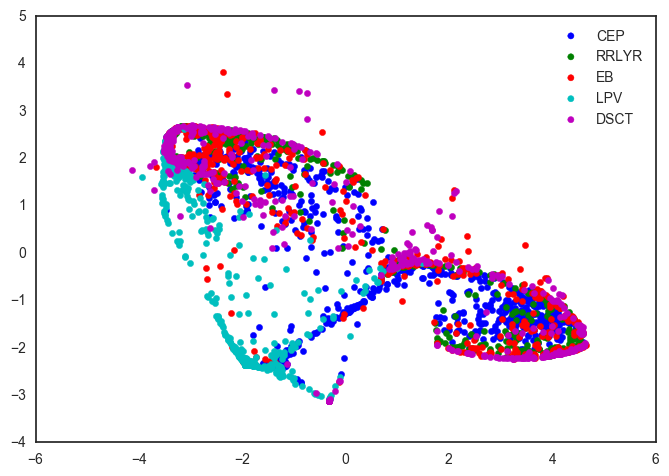

In [19]:
ut.plot_TSNE(OGLE_train, OGLE_label_train, n_iter_=1000, verbose_ = 1, perplexity_ = 1000)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 2647 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2648
[t-SNE] Computed conditional probabilities for sample 2000 / 2648
[t-SNE] Computed conditional probabilities for sample 2648 / 2648
[t-SNE] Mean sigma: 0.380225
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.040497
[t-SNE] Error after 100 iterations: 0.040497


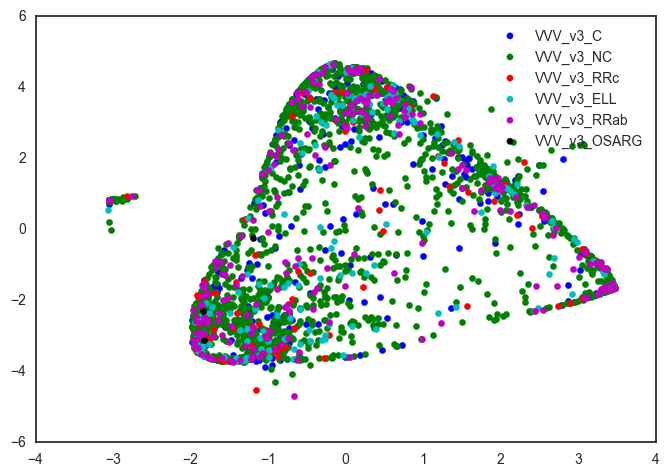

In [20]:
ut.plot_TSNE(vvv_train, vvv_label_train, n_iter_=1000, verbose_ = 1, perplexity_ = 1000)

# Classification of variable stars

Literature review of classification:  
 - surveys
 - models

Logistic Regression: 
- Deterministic model
\\[f(t) = \frac{1}{1+e^{-(\beta_0+\beta_1*t)}}\\]
- Bayesian model 

Model estimation: 
 - Deterministic model 
 
 - Bayesian model

In [7]:
obs_fold = 100
results = []
for i in range(len(OGLE_label_train.unique())): 
    for j in range(len(OGLE_label_train.unique())):
        for k in [1,2,3,4,5,6,7,8]:
            if j > i:
                print(OGLE_label_train.unique()[i], OGLE_label_train.unique()[j])
                results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= OGLE_label_train.unique()[i],class_2=OGLE_label_train.unique()[j], components= [k], method=[7], size=[0.5], ml= True, 
                                                                                                     fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
                label_ogle = dataTrain_ogle['label']
                labelTest_ogle = dataTest_ogle['label']
                del dataTrain_ogle['label']
                del dataTest_ogle['label']

                r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
                predictions_1_Train = ut.logistic_function_(r).mean(axis=1)>0.5
                print('Accuracy train: ', accuracy_score(label_ogle, predictions_1_Train, normalize=True))

                r = ut.get_z(dataTest_ogle, trace = trace_ogle, burn_in = 500)
                predictions_1_Test = ut.logistic_function_(r).mean(axis=1)>0.5
                print('Accuracy test: ', accuracy_score(labelTest_ogle, predictions_1_Test, normalize=True))


                dataTrain = dataTrain_ogle
                labelTrain = label_ogle
                dataTest = dataTest_ogle
                labelTest = labelTest_ogle

                n_split_train = 10 #int(dataTrain.shape[0]/obs_fold)
                n_split_test = 10 #int(dataTest.shape[0]/ obs_fold)
                clf1 = linearModel.LogisticRegression(C=1.0)
                acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf1)

                print('Accuracy train deterministic', np.mean(acc_kfold))
                print('Accuracy test deterministic', np.mean(acc_kfold_Test))
                
                results.append([results_summary_ogle, accuracy_score(label_ogle, predictions_1_Train, normalize=True), accuracy_score(labelTest_ogle, predictions_1_Test, normalize=True), np.mean(acc_kfold), np.mean(acc_kfold_Test), acc_kfold, acc_kfold_Test])

CEP EB
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:24<00:00, 432.12it/s]
The number of effective samples is smaller than 25% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -820.10955
return the last model and trace
Accuracy train:  0.650326797386
Accuracy test:  0.664735099338
Training...
Testing...
Accuracy train deterministic 0.650460256669
Accuracy test deterministic 0.663829201102
CEP EB
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:42<00:00, 246.79it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -816.79238
return the last model and trace
Accuracy train:  0.641339869281
Accuracy test:  0.656456953642
Training...
Testing...
Accuracy train deterministic 0.648007794128
Accuracy test deterministic 0.662982093664
CEP EB
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 213.84it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -815.14258
return the last model and trace
Accuracy train:  0.665849673203
Accuracy test:  0.673841059603
Training...
Testing...
Accuracy train deterministic 0.661909561244
Accuracy test deterministic 0.675385674931
CEP EB
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:00<00:00, 173.00it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -800.29201
return the last model and trace
Accuracy train:  0.674019607843
Accuracy test:  0.692880794702
Training...
Testing...
Accuracy train deterministic 0.664362023786
Accuracy test deterministic 0.675392561983
CEP EB
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:08<00:00, 153.42it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -617.40727
return the last model and trace
Accuracy train:  0.773692810458
Accuracy test:  0.775662251656
Training...
Testing...
Accuracy train deterministic 0.728885305382
Accuracy test deterministic 0.743326446281
CEP EB
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:30<00:00, 116.09it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -314.63551
return the last model and trace
Accuracy train:  0.922385620915
Accuracy test:  0.918046357616
Training...
Testing...
Accuracy train deterministic 0.760753880266
Accuracy test deterministic 0.763230027548
CEP EB
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:45<00:00, 99.96it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -317.92985
return the last model and trace
Accuracy train:  0.921568627451
Accuracy test:  0.918046357616
Training...
Testing...
Accuracy train deterministic 0.759927433985
Accuracy test deterministic 0.763230027548
CEP EB
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [02:02<00:00, 85.63it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -322.41546
return the last model and trace
Accuracy train:  0.919934640523
Accuracy test:  0.916390728477
Training...
Testing...
Accuracy train deterministic 0.759927433985
Accuracy test deterministic 0.763230027548
CEP DSCT
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:24<00:00, 425.41it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -800.80834
return the last model and trace
Accuracy train:  0.654320987654
Accuracy test:  0.671544715447
Training...
Testing...
Accuracy train deterministic 0.653519848259
Accuracy test deterministic 0.673981805127
CEP DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:35<00:00, 297.96it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -800.85242
return the last model and trace
Accuracy train:  0.645267489712
Accuracy test:  0.668292682927
Training...
Testing...
Accuracy train deterministic 0.64695569706
Accuracy test deterministic 0.666637968469
CEP DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:50<00:00, 208.40it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -793.34346
return the last model and trace
Accuracy train:  0.669958847737
Accuracy test:  0.7
Training...
Testing...
Accuracy train deterministic 0.670049902904
Accuracy test deterministic 0.699225363618
CEP DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:00<00:00, 174.17it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -611.52444
return the last model and trace
Accuracy train:  0.82633744856
Accuracy test:  0.821951219512
Training...
Testing...
Accuracy train deterministic 0.716087589757
Accuracy test deterministic 0.744721358768
CEP DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:06<00:00, 158.65it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -488.42584
return the last model and trace
Accuracy train:  0.82304526749
Accuracy test:  0.835772357724
Training...
Testing...
Accuracy train deterministic 0.777904190941
Accuracy test deterministic 0.783753487852
CEP DSCT
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:22<00:00, 127.87it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -273.98981
return the last model and trace
Accuracy train:  0.945679012346
Accuracy test:  0.924390243902
Training...
Testing...
Accuracy train deterministic 0.783655557061
Accuracy test deterministic 0.78538606063
CEP DSCT
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:49<00:00, 96.09it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -277.65856
return the last model and trace
Accuracy train:  0.946502057613
Accuracy test:  0.919512195122
Training...
Testing...
Accuracy train deterministic 0.785315336675
Accuracy test deterministic 0.786205732761
CEP DSCT
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:55<00:00, 90.71it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -281.98216
return the last model and trace
Accuracy train:  0.944855967078
Accuracy test:  0.919512195122
Training...
Testing...
Accuracy train deterministic 0.785315336675
Accuracy test deterministic 0.78538606063
CEP RRLYR
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:23<00:00, 443.18it/s]
The number of effective samples is smaller than 25% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -810.93904
return the last model and trace
Accuracy train:  0.61652892562
Accuracy test:  0.620408163265
Training...
Testing...
Accuracy train deterministic 0.609935419771
Accuracy test deterministic 0.617102360158
CEP RRLYR
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:36<00:00, 290.21it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -739.57835
return the last model and trace
Accuracy train:  0.704132231405
Accuracy test:  0.684081632653
Training...
Testing...
Accuracy train deterministic 0.703232285598
Accuracy test deterministic 0.701990829013
CEP RRLYR
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:48<00:00, 216.61it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -742.19879
return the last model and trace
Accuracy train:  0.720661157025
Accuracy test:  0.72
Training...
Testing...
Accuracy train deterministic 0.725567560854
Accuracy test deterministic 0.728074169781
CEP RRLYR
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:00<00:00, 172.86it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -660.45145
return the last model and trace
Accuracy train:  0.780165289256
Accuracy test:  0.734693877551
Training...
Testing...
Accuracy train deterministic 0.755382626564
Accuracy test deterministic 0.759163276838
CEP RRLYR
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:10<00:00, 149.90it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -610.70964
return the last model and trace
Accuracy train:  0.747933884298
Accuracy test:  0.764897959184
Training...
Testing...
Accuracy train deterministic 0.765348078399
Accuracy test deterministic 0.775483635747
CEP RRLYR
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:28<00:00, 118.71it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -515.47862
return the last model and trace
Accuracy train:  0.842148760331
Accuracy test:  0.789387755102
Training...
Testing...
Accuracy train deterministic 0.75380470126
Accuracy test deterministic 0.768999783007
CEP RRLYR
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:43<00:00, 101.84it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -520.37112
return the last model and trace
Accuracy train:  0.839669421488
Accuracy test:  0.789387755102
Training...
Testing...
Accuracy train deterministic 0.75380470126
Accuracy test deterministic 0.768999783007
CEP RRLYR
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:55<00:00, 90.58it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -524.85629
return the last model and trace
Accuracy train:  0.840495867769
Accuracy test:  0.784489795918
Training...
Testing...
Accuracy train deterministic 0.753804588357
Accuracy test deterministic 0.767360328596
CEP LPV
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:21<00:00, 478.46it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -687.51426
return the last model and trace
Accuracy train:  0.646610169492
Accuracy test:  0.656666666667
Training...
Testing...
Accuracy train deterministic 0.645733738954
Accuracy test deterministic 0.657531599417
CEP LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:32<00:00, 327.92it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -335.81930
return the last model and trace
Accuracy train:  0.886440677966
Accuracy test:  0.864166666667
Training...
Testing...
Accuracy train deterministic 0.886500754148
Accuracy test deterministic 0.862356934509
CEP LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:42<00:00, 245.18it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -343.11136
return the last model and trace
Accuracy train:  0.886440677966
Accuracy test:  0.865
Training...
Testing...
Accuracy train deterministic 0.883958016062
Accuracy test deterministic 0.863225050351
CEP LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:53<00:00, 196.96it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -338.63346
return the last model and trace
Accuracy train:  0.897457627119
Accuracy test:  0.88
Training...
Testing...
Accuracy train deterministic 0.889028518839
Accuracy test deterministic 0.879044841077
CEP LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:01<00:00, 169.48it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -318.90844
return the last model and trace
Accuracy train:  0.892372881356
Accuracy test:  0.88
Training...
Testing...
Accuracy train deterministic 0.883103193472
Accuracy test deterministic 0.873204504942
CEP LPV
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:20<00:00, 130.27it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -270.71602
return the last model and trace
Accuracy train:  0.933050847458
Accuracy test:  0.9275
Training...
Testing...
Accuracy train deterministic 0.883943529607
Accuracy test deterministic 0.873204504942
CEP LPV
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:34<00:00, 111.53it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -273.56675
return the last model and trace
Accuracy train:  0.935593220339
Accuracy test:  0.930833333333
Training...
Testing...
Accuracy train deterministic 0.883943529607
Accuracy test deterministic 0.872371171609
CEP LPV
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:46<00:00, 98.67it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -278.56472
return the last model and trace
Accuracy train:  0.936440677966
Accuracy test:  0.93
Training...
Testing...
Accuracy train deterministic 0.884783865741
Accuracy test deterministic 0.872371171609
EB DSCT
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:20<00:00, 509.80it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -692.42708
return the last model and trace
Accuracy train:  0.506598984772
Accuracy test:  0.510395010395
Training...
Testing...
Accuracy train deterministic 0.508565031761
Accuracy test deterministic 0.508301116838
EB DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:31<00:00, 337.17it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -700.30660
return the last model and trace
Accuracy train:  0.52385786802
Accuracy test:  0.529106029106
Training...
Testing...
Accuracy train deterministic 0.518717790146
Accuracy test deterministic 0.531142611684
EB DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:42<00:00, 247.11it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -707.63734
return the last model and trace
Accuracy train:  0.529949238579
Accuracy test:  0.525987525988
Training...
Testing...
Accuracy train deterministic 0.53088023088
Accuracy test deterministic 0.52912371134
EB DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:52<00:00, 198.20it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -674.94362
return the last model and trace
Accuracy train:  0.596954314721
Accuracy test:  0.570686070686
Training...
Testing...
Accuracy train deterministic 0.577604893879
Accuracy test deterministic 0.579112972509
EB DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:04<00:00, 163.43it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -676.74964
return the last model and trace
Accuracy train:  0.629441624365
Accuracy test:  0.599792099792
Training...
Testing...
Accuracy train deterministic 0.579656017359
Accuracy test deterministic 0.606121134021
EB DSCT
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:15<00:00, 139.82it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -671.95852
return the last model and trace
Accuracy train:  0.619289340102
Accuracy test:  0.68814968815
Training...
Testing...
Accuracy train deterministic 0.57469933928
Accuracy test deterministic 0.601932989691
EB DSCT
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:27<00:00, 120.36it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -669.35613
return the last model and trace
Accuracy train:  0.628426395939
Accuracy test:  0.681912681913
Training...
Testing...
Accuracy train deterministic 0.576740368125
Accuracy test deterministic 0.602974656357
EB DSCT
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:48<00:00, 96.77it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -672.31698
return the last model and trace
Accuracy train:  0.633502538071
Accuracy test:  0.653846153846
Training...
Testing...
Accuracy train deterministic 0.57570944029
Accuracy test deterministic 0.601932989691
EB RRLYR
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:20<00:00, 511.54it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -689.82163
return the last model and trace
Accuracy train:  0.509183673469
Accuracy test:  0.495297805643
Training...
Testing...
Accuracy train deterministic 0.485775597337
Accuracy test deterministic 0.486853070175
EB RRLYR
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:30<00:00, 344.20it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -663.72105
return the last model and trace
Accuracy train:  0.608163265306
Accuracy test:  0.626959247649
Training...
Testing...
Accuracy train deterministic 0.618354702081
Accuracy test deterministic 0.622708333333
EB RRLYR
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:41<00:00, 253.10it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -666.49490
return the last model and trace
Accuracy train:  0.614285714286
Accuracy test:  0.599791013584
Training...
Testing...
Accuracy train deterministic 0.615261918576
Accuracy test deterministic 0.608048245614
EB RRLYR
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:51<00:00, 202.83it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -666.47493
return the last model and trace
Accuracy train:  0.619387755102
Accuracy test:  0.603970741902
Training...
Testing...
Accuracy train deterministic 0.614251817566
Accuracy test deterministic 0.609100877193
EB RRLYR
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:01<00:00, 170.40it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -658.54806
return the last model and trace
Accuracy train:  0.642857142857
Accuracy test:  0.633228840125
Training...
Testing...
Accuracy train deterministic 0.639648642962
Accuracy test deterministic 0.636271929825
EB RRLYR
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:13<00:00, 142.68it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -578.68156
return the last model and trace
Accuracy train:  0.739795918367
Accuracy test:  0.764890282132
Training...
Testing...
Accuracy train deterministic 0.677458468548
Accuracy test deterministic 0.691622807018
EB RRLYR
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:24<00:00, 124.08it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -581.80621
return the last model and trace
Accuracy train:  0.739795918367
Accuracy test:  0.762800417973
Training...
Testing...
Accuracy train deterministic 0.67439703154
Accuracy test deterministic 0.691622807018
EB RRLYR
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [01:45<00:00, 99.19it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -587.33924
return the last model and trace
Accuracy train:  0.740816326531
Accuracy test:  0.762800417973
Training...
Testing...
Accuracy train deterministic 0.675427959375
Accuracy test deterministic 0.692675438596
EB LPV
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:19<00:00, 530.20it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -641.20535
return the last model and trace
Accuracy train:  0.513684210526
Accuracy test:  0.511802575107
Training...
Testing...
Accuracy train deterministic 0.512665406868
Accuracy test deterministic 0.513006177076
EB LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:27<00:00, 384.57it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -287.93890
return the last model and trace
Accuracy train:  0.929473684211
Accuracy test:  0.8830472103
Training...
Testing...
Accuracy train deterministic 0.885310283688
Accuracy test deterministic 0.909837565774
EB LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:36<00:00, 291.14it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -274.04038
return the last model and trace
Accuracy train:  0.943157894737
Accuracy test:  0.901287553648
Training...
Testing...
Accuracy train deterministic 0.885310283688
Accuracy test deterministic 0.91520247083
EB LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:45<00:00, 231.52it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -276.89759
return the last model and trace
Accuracy train:  0.942105263158
Accuracy test:  0.902360515021
Training...
Testing...
Accuracy train deterministic 0.886374113475
Accuracy test deterministic 0.909837565774
EB LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:55<00:00, 190.74it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -280.01411
return the last model and trace
Accuracy train:  0.918947368421
Accuracy test:  0.910944206009
Training...
Testing...
Accuracy train deterministic 0.884290780142
Accuracy test deterministic 0.932395332876
EB LPV
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:04<00:00, 161.81it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -272.76673
return the last model and trace
Accuracy train:  0.946315789474
Accuracy test:  0.908798283262
Training...
Testing...
Accuracy train deterministic 0.888490574841
Accuracy test deterministic 0.928082818577
EB LPV
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:14<00:00, 140.23it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -271.11399
return the last model and trace
Accuracy train:  0.946315789474
Accuracy test:  0.916309012876
Training...
Testing...
Accuracy train deterministic 0.890596071295
Accuracy test deterministic 0.930233356211
EB LPV
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:34<00:00, 111.03it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -274.99115
return the last model and trace
Accuracy train:  0.947368421053
Accuracy test:  0.915236051502
Training...
Testing...
Accuracy train deterministic 0.889554404629
Accuracy test deterministic 0.930233356211
DSCT RRLYR
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:20<00:00, 512.56it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -681.86492
return the last model and trace
Accuracy train:  0.492276004119
Accuracy test:  0.492339121553
Training...
Testing...
Accuracy train deterministic 0.492320420436
Accuracy test deterministic 0.492217355546
DSCT RRLYR
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:30<00:00, 348.19it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -650.44370
return the last model and trace
Accuracy train:  0.643666323378
Accuracy test:  0.651685393258
Training...
Testing...
Accuracy train deterministic 0.640516515885
Accuracy test deterministic 0.642390558223
DSCT RRLYR
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:40<00:00, 261.91it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -641.85767
return the last model and trace
Accuracy train:  0.613800205973
Accuracy test:  0.631256384065
Training...
Testing...
Accuracy train deterministic 0.63436206957
Accuracy test deterministic 0.635278622539
DSCT RRLYR
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:51<00:00, 203.95it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -633.86132
return the last model and trace
Accuracy train:  0.634397528321
Accuracy test:  0.67620020429
Training...
Testing...
Accuracy train deterministic 0.634319552563
Accuracy test deterministic 0.649564761862
DSCT RRLYR
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:10<00:00, 149.36it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -604.16514
return the last model and trace
Accuracy train:  0.676622039135
Accuracy test:  0.737487231869
Training...
Testing...
Accuracy train deterministic 0.642631189074
Accuracy test deterministic 0.666965149071
DSCT RRLYR
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:19<00:00, 131.27it/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -584.25811
return the last model and trace
Accuracy train:  0.714727085479
Accuracy test:  0.771195097038
Training...
Testing...
Accuracy train deterministic 0.669457447928
Accuracy test deterministic 0.70472216378
DSCT RRLYR
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:23<00:00, 125.01it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -582.87159
return the last model and trace
Accuracy train:  0.729145211123
Accuracy test:  0.76608784474
Training...
Testing...
Accuracy train deterministic 0.669457447928
Accuracy test deterministic 0.705753091615
DSCT RRLYR
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:43<00:00, 101.12it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -585.59349
return the last model and trace
Accuracy train:  0.732234809475
Accuracy test:  0.749744637385
Training...
Testing...
Accuracy train deterministic 0.670477856091
Accuracy test deterministic 0.702691654606
DSCT LPV
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:19<00:00, 526.51it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -645.88762
return the last model and trace
Accuracy train:  0.501594048884
Accuracy test:  0.496855345912
Training...
Testing...
Accuracy train deterministic 0.500617828029
Accuracy test deterministic 0.49504069452
DSCT LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:27<00:00, 387.80it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -289.05968
return the last model and trace
Accuracy train:  0.857598299681
Accuracy test:  0.82285115304
Training...
Testing...
Accuracy train deterministic 0.835300003612
Accuracy test deterministic 0.847976125882
DSCT LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:36<00:00, 290.94it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -280.62490
return the last model and trace
Accuracy train:  0.877789585547
Accuracy test:  0.876310272537
Training...
Testing...
Accuracy train deterministic 0.8363638334
Accuracy test deterministic 0.847976125882
DSCT LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 243.85it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -252.54835
return the last model and trace
Accuracy train:  0.902231668438
Accuracy test:  0.883647798742
Training...
Testing...
Accuracy train deterministic 0.864024852798
Accuracy test deterministic 0.854357026587
DSCT LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:52<00:00, 199.94it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -246.63080
return the last model and trace
Accuracy train:  0.912858660999
Accuracy test:  0.946540880503
Training...
Testing...
Accuracy train deterministic 0.86617514961
Accuracy test deterministic 0.86378730331
DSCT LPV
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:02<00:00, 168.98it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -245.33149
return the last model and trace
Accuracy train:  0.911795961743
Accuracy test:  0.915094339623
Training...
Testing...
Accuracy train deterministic 0.865099880793
Accuracy test deterministic 0.864839934889
DSCT LPV
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:11<00:00, 147.28it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -172.60869
return the last model and trace
Accuracy train:  0.946865037194
Accuracy test:  0.939203354298
Training...
Testing...
Accuracy train deterministic 0.87679153271
Accuracy test deterministic 0.880564297341
DSCT LPV
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:28<00:00, 118.86it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -152.62638
return the last model and trace
Accuracy train:  0.955366631243
Accuracy test:  0.930817610063
Training...
Testing...
Accuracy train deterministic 0.87679153271
Accuracy test deterministic 0.880564297341
RRLYR LPV
1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:19<00:00, 538.00it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -627.82855
return the last model and trace
Accuracy train:  0.520299145299
Accuracy test:  0.511064278188
Training...
Testing...
Accuracy train deterministic 0.520441426146
Accuracy test deterministic 0.511074561404
RRLYR LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:24<00:00, 431.71it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -130.61963
return the last model and trace
Accuracy train:  0.958333333333
Accuracy test:  0.944151738672
Training...
Testing...
Accuracy train deterministic 0.973299377476
Accuracy test deterministic 0.950379572602
RRLYR LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:31<00:00, 328.90it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -128.82418
return the last model and trace
Accuracy train:  0.959401709402
Accuracy test:  0.945205479452
Training...
Testing...
Accuracy train deterministic 0.973299377476
Accuracy test deterministic 0.950379572602
RRLYR LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:40<00:00, 257.06it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -133.50549
return the last model and trace
Accuracy train:  0.959401709402
Accuracy test:  0.944151738672
Training...
Testing...
Accuracy train deterministic 0.971148839842
Accuracy test deterministic 0.950379572602
RRLYR LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 212.05it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -123.68760
return the last model and trace
Accuracy train:  0.972222222222
Accuracy test:  0.943097997893
Training...
Testing...
Accuracy train deterministic 0.973299377476
Accuracy test deterministic 0.949326941023
RRLYR LPV
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:57<00:00, 181.09it/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -104.75910
return the last model and trace
Accuracy train:  0.969017094017
Accuracy test:  0.939936775553
Training...
Testing...
Accuracy train deterministic 0.977555178268
Accuracy test deterministic 0.95039077081
RRLYR LPV
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:07<00:00, 155.61it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -111.13550
return the last model and trace
Accuracy train:  0.969017094017
Accuracy test:  0.944151738672
Training...
Testing...
Accuracy train deterministic 0.978607809847
Accuracy test deterministic 0.95039077081
RRLYR LPV
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:25<00:00, 123.33it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -113.33261
return the last model and trace
Accuracy train:  0.971153846154
Accuracy test:  0.944151738672
Training...
Testing...
Accuracy train deterministic 0.978607809847
Accuracy test deterministic 0.95039077081


In [19]:
thefile = open('Results03082018.txt', 'w')
for item in results:
    thefile.write("%s\n" % item)

In [20]:
f = open("Results03082018.txt","r") #opens file with name of "test.txt"
myList = []
for line in f:
    myList.append(line)

In [28]:
myList[1].split()[8:12]

['0.65032679738562094,',
 '0.66473509933774833,',
 '0.65046025666868246,',
 '0.66382920110192845,']

In [22]:
results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= 'RRLYR',class_2='LPV', components= [1,2,3,4,5,6,7,8], method=[7], size=[0.5], ml= True, 
                                                                                                 fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
results_summary_ogle

1
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:22<00:00, 464.86it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -627.83054
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:25<00:00, 409.85it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -130.60736
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:31<00:00, 328.46it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -128.80810
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:47<00:00, 220.99it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -133.47092
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:57<00:00, 183.08it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -123.51333
6
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:11<00:00, 147.73it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -105.95481
7
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:14<00:00, 140.22it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -110.73852
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:41<00:00, 103.63it/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -115.43768
return the last model and trace


,0,1,2,3,4,5,6
0,1,7,67.490302,11.729469,-627.830543,1238.454309,0.5
1,2,7,55.759045,7.975436,-130.607360,234.793419,0.5
2,3,7,67.641980,8.170659,-128.808098,224.891000,0.5
3,4,7,101.620549,8.756482,-133.470924,226.560758,0.5
4,5,7,117.696760,16.840083,-123.513325,207.291118,0.5
5,6,7,177.238582,12.360597,-105.954807,170.746595,0.5
6,7,7,206.977076,12.240863,-110.738520,173.824951,0.5
7,8,7,202.849164,11.622434,-115.437677,171.358179,0.5


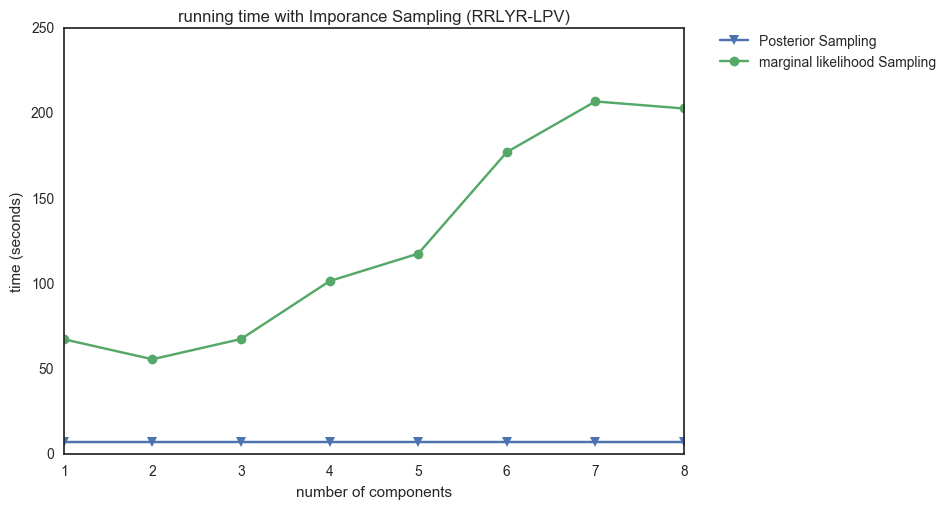

In [23]:
plt.plot(results_summary_ogle[0], results_summary_ogle[1], label="Posterior Sampling", marker = "v")
plt.plot(results_summary_ogle[0], results_summary_ogle[2], label="marginal likelihood Sampling", marker = "o")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('running time with Imporance Sampling (RRLYR-LPV)')
plt.ylabel('time (seconds)')
plt.xlabel('number of components')
plt.show()

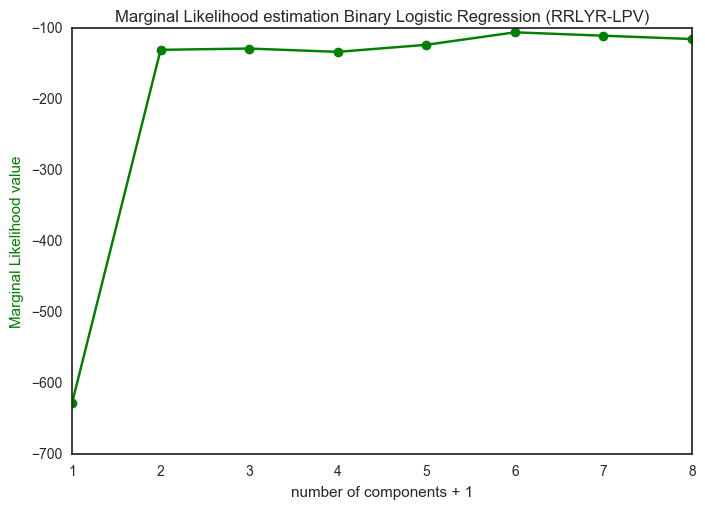

In [42]:
plt.plot(results_summary_ogle[0], results_summary_ogle[4], marker = "o", color ='g')
plt.title('Marginal Likelihood estimation Binary Logistic Regression (RRLYR-LPV)')
plt.ylabel('Marginal Likelihood value', color = 'g')
plt.xlabel('number of components + 1')
plt.show()

In [46]:
for i in range(len(OGLE_label_train.unique())): 
    for j in range(len(OGLE_label_train.unique())):
        if j > i:
            print(OGLE_label_train.unique()[i], OGLE_label_train.unique()[j])
            results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= OGLE_label_train.unique()[i],class_2=OGLE_label_train.unique()[j], components= [2], method=[7], size=[0.5], ml= True, 
                                                                                                 fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
            label_ogle = dataTrain_ogle['label']
            labelTest_ogle = dataTest_ogle['label']
            del dataTrain_ogle['label']
            del dataTest_ogle['label']
            r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
            predictions_1 = ut.logistic_function_(r).mean(axis=1)>0.5
            print(accuracy_score(label_ogle, predictions_1, normalize=True))

CEP RRLYR
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:38<00:00, 273.30it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -739.58009
return the last model and trace
0.704958677686
CEP EB
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 240.72it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -816.79251
return the last model and trace
0.640522875817
CEP LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:34<00:00, 306.12it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -335.81577
return the last model and trace
0.887288135593
CEP DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:37<00:00, 277.15it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -800.85225
return the last model and trace
0.645267489712
RRLYR EB
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:32<00:00, 319.07it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -663.71997
return the last model and trace
0.611224489796
RRLYR LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:26<00:00, 399.99it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -130.60087
return the last model and trace
0.959401709402
RRLYR DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:32<00:00, 323.44it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -650.44141
return the last model and trace
0.643666323378
EB LPV
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:29<00:00, 358.11it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -287.93984
return the last model and trace
0.929473684211
EB DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:33<00:00, 315.00it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -700.30584
return the last model and trace
0.525888324873
LPV DSCT
2
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:31<00:00, 331.63it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -288.53292
return the last model and trace
0.858660998937


In [47]:
for i in range(len(OGLE_label_train.unique())): 
    for j in range(len(OGLE_label_train.unique())):
        if j > i:
            print(OGLE_label_train.unique()[i], OGLE_label_train.unique()[j])
            results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= OGLE_label_train.unique()[i],class_2=OGLE_label_train.unique()[j], components= [3], method=[7], size=[0.5], ml= True, 
                                                                                                 fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
            label_ogle = dataTrain_ogle['label']
            labelTest_ogle = dataTest_ogle['label']
            del dataTrain_ogle['label']
            del dataTest_ogle['label']
            r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
            predictions_1 = ut.logistic_function_(r).mean(axis=1)>0.5
            print(accuracy_score(label_ogle, predictions_1, normalize=True))

CEP RRLYR
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 213.95it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -742.19736
return the last model and trace
0.720661157025
CEP EB
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 212.42it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -815.14214
return the last model and trace
0.665849673203
CEP LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 239.49it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -343.11888
return the last model and trace
0.885593220339
CEP DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:48<00:00, 217.34it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -793.34335
return the last model and trace
0.672427983539
RRLYR EB
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:41<00:00, 251.57it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -666.49088
return the last model and trace
0.616326530612
RRLYR LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:32<00:00, 321.22it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -128.81880
return the last model and trace
0.959401709402
RRLYR DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:42<00:00, 245.18it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -641.85309
return the last model and trace
0.612770339856
EB LPV
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:40<00:00, 261.46it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -274.06001
return the last model and trace
0.944210526316
EB DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 213.01it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -707.63705
return the last model and trace
0.528934010152
LPV DSCT
3
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 241.53it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -263.24083
return the last model and trace
0.888416578108


In [48]:
for i in range(len(OGLE_label_train.unique())): 
    for j in range(len(OGLE_label_train.unique())):
        if j > i:
            print(OGLE_label_train.unique()[i], OGLE_label_train.unique()[j])
            results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= OGLE_label_train.unique()[i],class_2=OGLE_label_train.unique()[j], components= [4], method=[7], size=[0.5], ml= True, 
                                                                                                 fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
            label_ogle = dataTrain_ogle['label']
            labelTest_ogle = dataTest_ogle['label']
            del dataTrain_ogle['label']
            del dataTest_ogle['label']
            r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
            predictions_1 = ut.logistic_function_(r).mean(axis=1)>0.5
            print(accuracy_score(label_ogle, predictions_1, normalize=True))

CEP RRLYR
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:01<00:00, 169.58it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -660.44591
return the last model and trace
0.780165289256
CEP EB
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:01<00:00, 171.73it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -800.28805
return the last model and trace
0.676470588235
CEP LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:54<00:00, 194.27it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -338.63726
return the last model and trace
0.896610169492
CEP DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:58<00:00, 178.13it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -611.52933
return the last model and trace
0.827160493827
RRLYR EB
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:52<00:00, 200.08it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -666.34856
return the last model and trace
0.621428571429
RRLYR LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:41<00:00, 255.17it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -133.49155
return the last model and trace
0.959401709402
RRLYR DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:51<00:00, 204.52it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -631.03395
return the last model and trace
0.641606591143
EB LPV
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:46<00:00, 224.09it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -276.91351
return the last model and trace
0.942105263158
EB DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:54<00:00, 194.06it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -674.94482
return the last model and trace
0.596954314721
LPV DSCT
4
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:45<00:00, 232.75it/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -250.55231
return the last model and trace
0.896918172157


In [49]:
for i in range(len(OGLE_label_train.unique())): 
    for j in range(len(OGLE_label_train.unique())):
        if j > i:
            print(OGLE_label_train.unique()[i], OGLE_label_train.unique()[j])
            results_summary_ogle, model_ogle, trace_ogle, dataTrain_ogle, dataTest_ogle = exp.runExperiments(OGLE,  class_1= OGLE_label_train.unique()[i],class_2=OGLE_label_train.unique()[j], components= [5], method=[7], size=[0.5], ml= True, 
                                                                                                 fit_iterations= 10000, name_class_col_= 'class_name', id_col_='ogle_id')
            label_ogle = dataTrain_ogle['label']
            labelTest_ogle = dataTest_ogle['label']
            del dataTrain_ogle['label']
            del dataTest_ogle['label']
            r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
            predictions_1 = ut.logistic_function_(r).mean(axis=1)>0.5
            print(accuracy_score(label_ogle, predictions_1, normalize=True))

CEP RRLYR
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:14<00:00, 141.68it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -610.69776
return the last model and trace
0.746280991736
CEP EB
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:15<00:00, 138.18it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -617.40633
return the last model and trace
0.773692810458
CEP LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:04<00:00, 162.92it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -318.92420
return the last model and trace
0.891525423729
CEP DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:08<00:00, 152.31it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -488.41526
return the last model and trace
0.822222222222
RRLYR EB
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:02<00:00, 166.91it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -658.54858
return the last model and trace
0.642857142857
RRLYR LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:49<00:00, 211.09it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -123.34128
return the last model and trace
0.971153846154
RRLYR DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:01<00:00, 171.61it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -604.24760
return the last model and trace
0.675592173018
EB LPV
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:56<00:00, 187.18it/s]
The number of effective samples is smaller than 10% for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -280.00174
return the last model and trace
0.917894736842
EB DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [01:04<00:00, 163.12it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -676.75134
return the last model and trace
0.631472081218
LPV DSCT
5
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:53<00:00, 196.37it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
10000
5000
10000
10000
The Bridge Sampling Estimatation of Logml is -250.59323
return the last model and trace
0.89904357067


In [7]:
print(dataTrain_ogle.shape)
print(dataTest_ogle.shape)

(936, 3)
(949, 3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E69D552A58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E6A747A828>]], dtype=object)

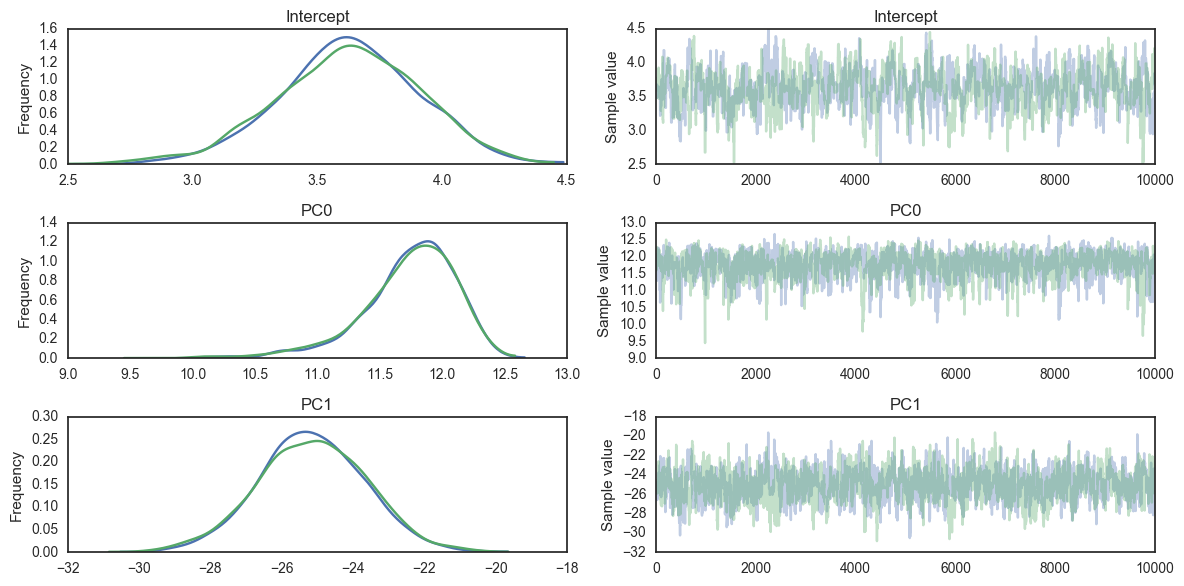

In [8]:
pm.traceplot(trace_ogle)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A68186D630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001A6860C66D8>]], dtype=object)

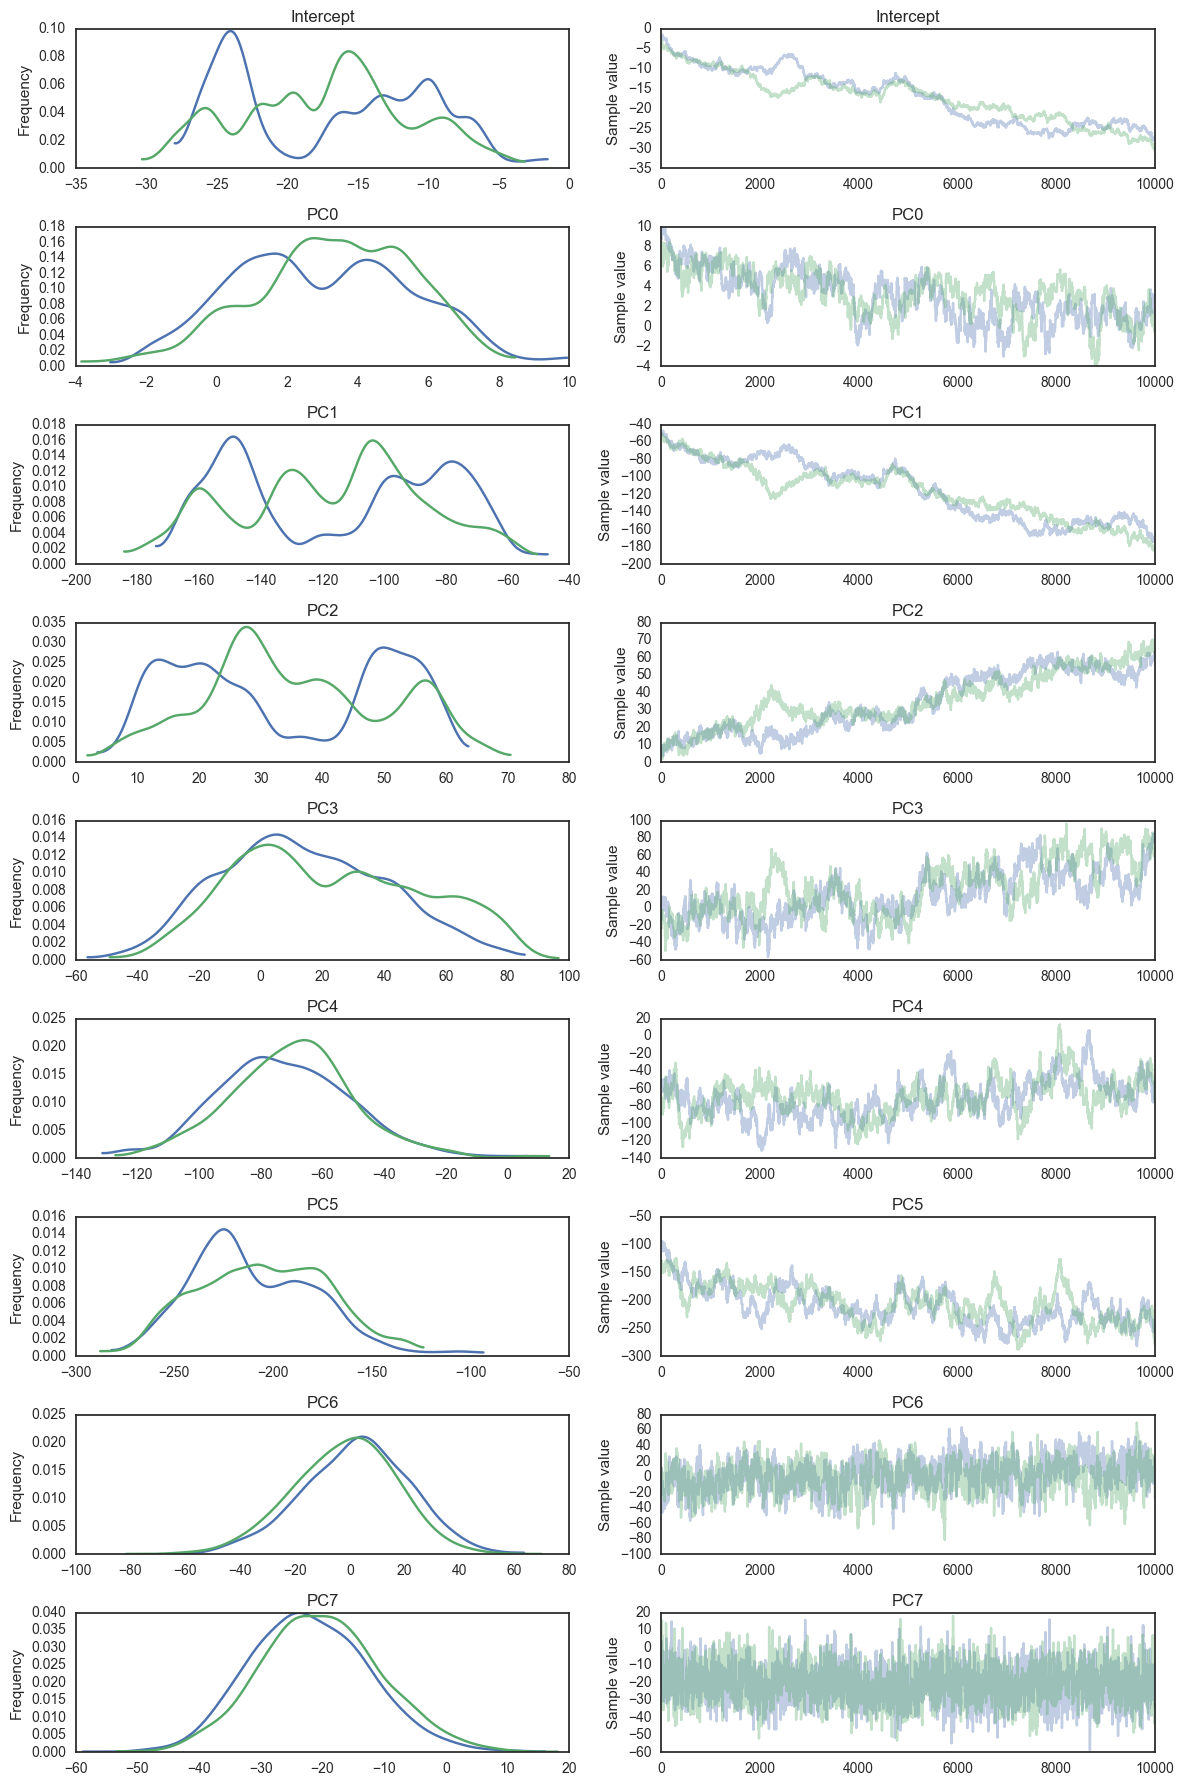

In [53]:
pm.traceplot(trace_ogle)

# Prediction using Bayesian Log Reg

In [9]:
label_ogle = dataTrain_ogle['label']
labelTest_ogle = dataTest_ogle['label']
del dataTrain_ogle['label']
del dataTest_ogle['label']

In [10]:
r = ut.get_z(dataTrain_ogle, trace = trace_ogle, burn_in = 500)
predictions_1 = ut.logistic_function_(r).mean(axis=1)>0.5
confusion_matrix(label_ogle, predictions_1)

array([[450,   3],
       [ 35, 448]])

In [11]:
accuracy_score(label_ogle, predictions_1, normalize=True)

0.95940170940170943

In [5]:
results_summary_vvv, model_vvv, trace_vvv, dataTrain_vvv, dataTest_vvv = exp.runExperiments(VVV,  components= [10], method=[4], size=[0.05], ml= True, fit_iterations= 2000)
results_summary_vvv

10
------- Slide Sampling--------


logp = -1,041.4, ||grad|| = 0.14961: 100%|███████████████████████████████████████████| 111/111 [00:01<00:00, 96.33it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [PC9]
>Slice: [PC8]
>Slice: [PC7]
>Slice: [PC6]
>Slice: [PC5]
>Slice: [PC4]
>Slice: [PC3]
>Slice: [PC2]
>Slice: [PC1]
>Slice: [PC0]
>Slice: [Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:25<00:00, 17.21it/s]
The number of effective samples is smaller than 25% for some parameters.


2
2000
1000
2000
2000
The Bridge Sampling Estimatation of Logml is -1011.59834
return the last model and trace


,0,1,2,3,4,5,6
0,10,4,326.4952,8.260208,-1011.598341,1964.982495,0.05


In [9]:
dataTrain.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,label
4,0.053878,0.053933,-0.047326,-0.007328,-0.006729,-0.002275,-0.003423,-0.003070,0.001740,-0.001033,0
8,0.031303,-0.060528,0.020495,-0.006926,-0.000076,0.000068,0.000221,-0.000282,0.000197,0.000031,0
19,0.006944,-0.042201,0.015611,-0.004122,0.000053,0.000051,0.000074,-0.000196,0.000162,0.000082,1
34,-0.032328,0.006359,-0.001640,0.002324,-0.002171,-0.000338,0.000253,0.000145,0.000196,-0.000187,1
50,-0.023123,-0.009678,0.004785,0.000549,-0.000054,0.000012,-0.000110,0.000043,0.000002,-0.000033,1


In [ ]:
label = dataTrain_vvv['label']
labelTest = dataTest_vvv['label']
del dataTrain_vvv['label']
del dataTest_vvv['label']

In [ ]:
r = get_z(dataTrain, trace = trace, burn_in = 500)
predictions_1 = logistic_function_(r).mean(axis=1)>0.5
confusion_matrix(label, predictions_1)

In [ ]:
accuracy_score(label, predictions_1, normalize=True)

In [13]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.403808,0.062142,0.001516,-0.522400,-0.276343,1690.228603,1.000536
PC0,-4.132775,1.120967,0.035797,-6.164501,-1.774548,1057.452466,1.005894
PC1,1.397635,1.591563,0.046982,-1.825718,4.375137,1068.921451,1.003776
PC2,0.213137,2.622044,0.066589,-4.842098,5.314451,1609.582678,1.000763
PC3,1.793315,6.415440,0.156979,-9.978610,14.912985,1916.505100,1.001243
PC4,-78.706243,18.511095,0.576129,-114.830730,-42.197941,1098.427099,1.002532
PC5,-4.521044,25.982585,0.502225,-55.853816,46.099150,2618.708324,1.001053
PC6,5.667410,27.074759,0.479359,-50.201910,56.485412,3503.527752,0.999764
PC7,-18.351990,28.848283,0.485563,-75.697153,36.119232,3171.127877,1.000902
PC8,59.305542,36.684764,0.759055,-8.722163,133.885472,1986.769444,1.001093


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A150A37B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022A16ADFDD8>]], dtype=object)

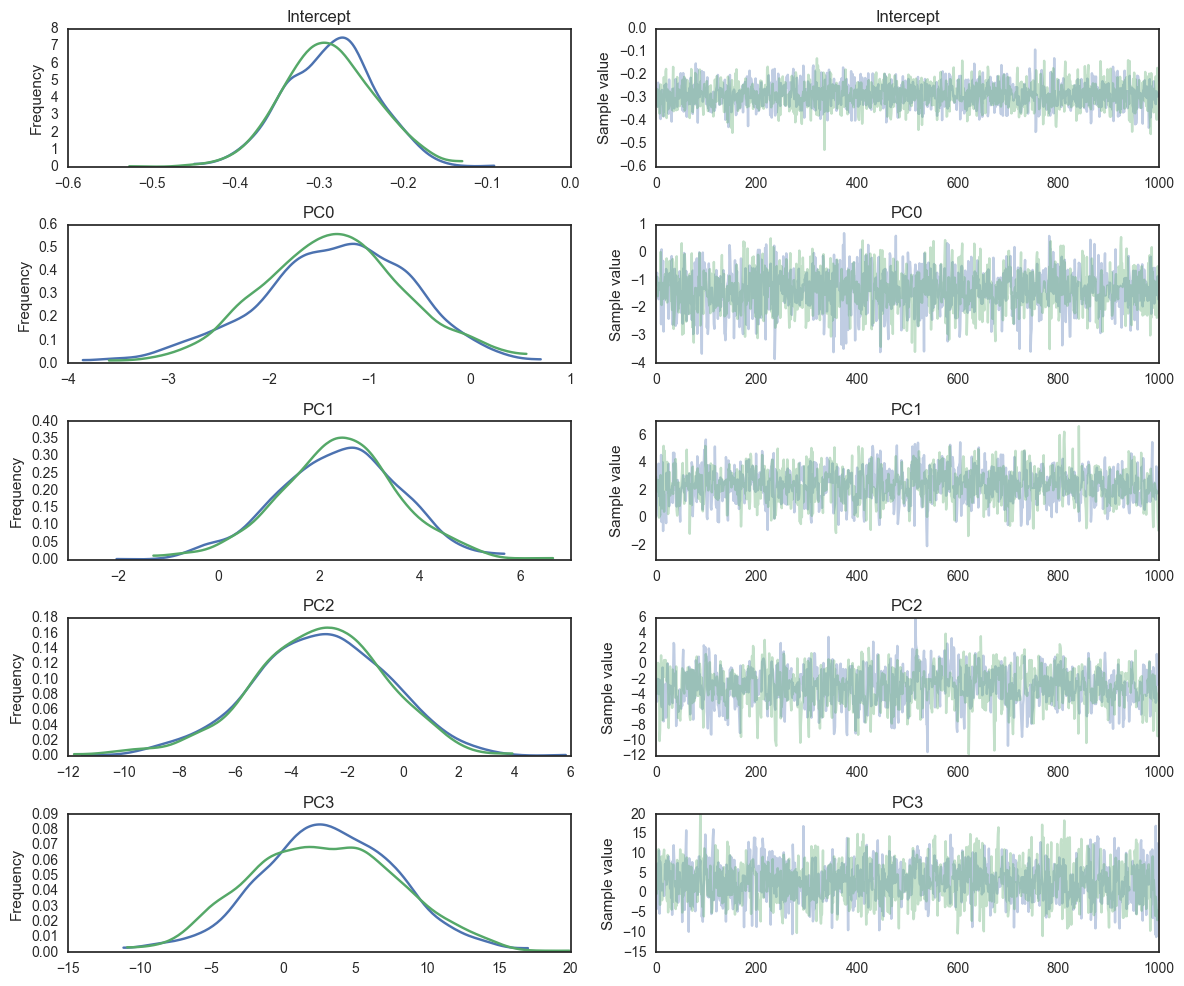

In [7]:
pm.traceplot(trace)

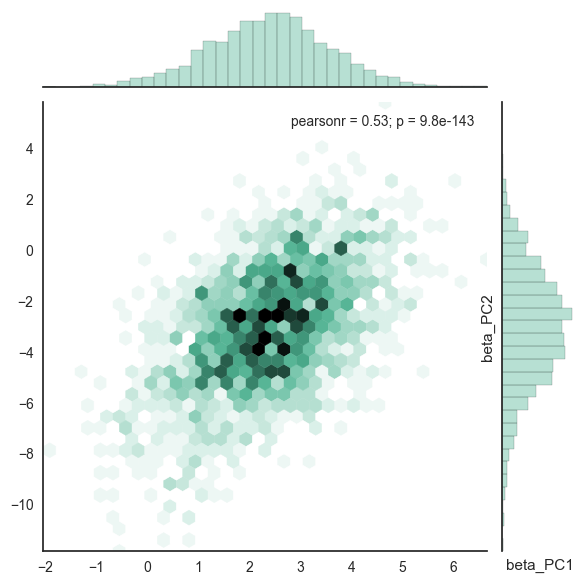

In [8]:
plt.figure(figsize=(9,7))
trace = trace
seaborn.jointplot(trace['PC1'], trace['PC2'], kind="hex", color="#4CB391")
plt.xlabel("beta_PC1")
plt.ylabel("beta_PC2")
plt.show()

It is important to comment that the majority of the time is consumming by the posterior sampling. Then, we can reduce the time process if we are able to develop an more efficient method for this stage. A interesting option is generate samples of posterior by Variational Inference.   

In [27]:
results_summary, model, approx = exp.runExperiments(VVV,  components= [4,5,6,7,8,9,10,15], method=[1], size=[0.05], ml= False)
results_summary

4
-------ADVI--------


INFO (theano.gof.compilelock): Refreshing lock C:\Users\frper\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.0-64\lock_dir\lock
logp = -1,006.8, ||grad|| = 0.58581: 100%|████████████████████████████████████████████| 41/41 [00:00<00:00, 486.79it/s]
Average Loss = 1,005.5: 100%|███████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 595.86it/s]
Finished [100%]: Average Loss = 1,005.5


5
-------ADVI--------


logp = -1,042.2, ||grad|| = 63.136: 100%|█████████████████████████████████████████████| 50/50 [00:00<00:00, 505.32it/s]
Average Loss = 1,010.3: 100%|███████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 555.79it/s]
Finished [100%]: Average Loss = 1,010.3


6
-------ADVI--------


logp = -1,012.5, ||grad|| = 1.038: 100%|██████████████████████████████████████████████| 49/49 [00:00<00:00, 490.46it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\frper\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.0-64\lock_dir\lock
Average Loss = 1,015.4: 100%|███████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 558.60it/s]
Finished [100%]: Average Loss = 1,015.4


7
-------ADVI--------


logp = -1,020, ||grad|| = 0.076835: 100%|█████████████████████████████████████████████| 73/73 [00:00<00:00, 397.44it/s]
Average Loss = 1,020.7: 100%|███████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 550.04it/s]
Finished [100%]: Average Loss = 1,020.7


8
-------ADVI--------


INFO (theano.gof.compilelock): Refreshing lock C:\Users\frper\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.0-64\lock_dir\lock
logp = -1,027.6, ||grad|| = 0.046703: 100%|███████████████████████████████████████████| 59/59 [00:00<00:00, 337.33it/s]
Average Loss = 1,026.2: 100%|███████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 548.69it/s]
Finished [100%]: Average Loss = 1,026.2


9
-------ADVI--------


logp = -1,035.1, ||grad|| = 3.6611: 100%|█████████████████████████████████████████████| 43/43 [00:00<00:00, 382.00it/s]
Average Loss = 1,031.2: 100%|███████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 507.91it/s]
Finished [100%]: Average Loss = 1,031.1


10
-------ADVI--------


INFO (theano.gof.compilelock): Refreshing lock C:\Users\frper\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.0-64\lock_dir\lock
logp = -1,041.4, ||grad|| = 0.97096: 100%|██████████████████████████████████████████| 151/151 [00:00<00:00, 309.58it/s]
Average Loss = 1,036.4: 100%|███████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.06it/s]
Finished [100%]: Average Loss = 1,036.4


15
-------ADVI--------


logp = -1,071.3, ||grad|| = 0.015007: 100%|█████████████████████████████████████████| 348/348 [00:00<00:00, 369.66it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\frper\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.0-64\lock_dir\lock
Average Loss = 1,063: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.51it/s]
Finished [100%]: Average Loss = 1,063


return the last model and trace


,0,1,2
0,4,22.612415,Approximation{MeanFieldGroup[5]}
1,5,24.873371,Approximation{MeanFieldGroup[6]}
2,6,31.781372,Approximation{MeanFieldGroup[7]}
3,7,31.990560,Approximation{MeanFieldGroup[8]}
4,8,34.728145,Approximation{MeanFieldGroup[9]}
5,9,33.264220,Approximation{MeanFieldGroup[10]}
6,10,34.960810,Approximation{MeanFieldGroup[11]}
7,15,45.280364,Approximation{MeanFieldGroup[16]}


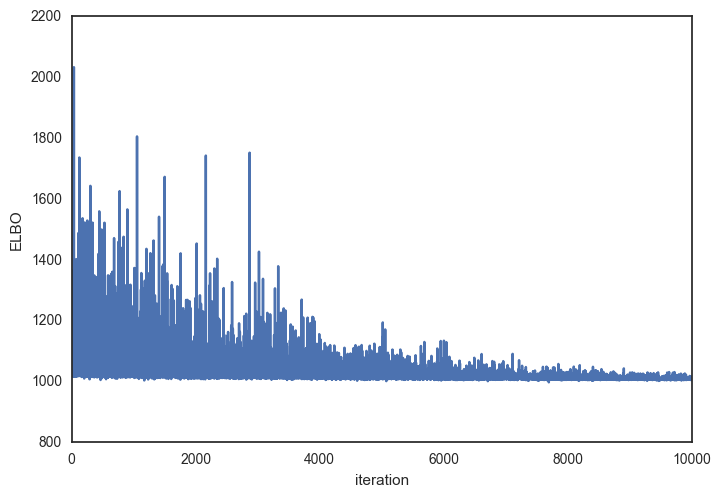

In [20]:
plt.plot(approx.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')

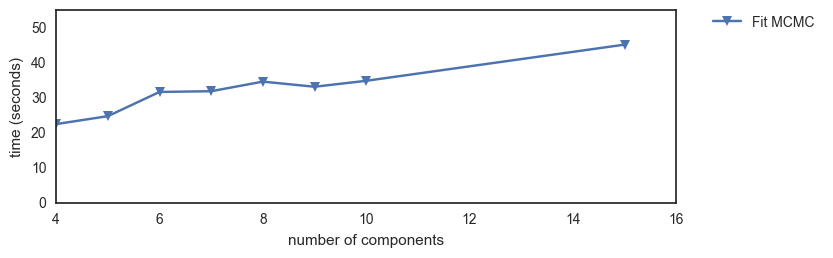

In [28]:
plt.figure(1)
plt.subplot(211)
plt.plot(results_summary[0], results_summary[1], label="Fit MCMC ", marker = "v")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, np.max(results_summary[1]+10))
plt.ylabel('time (seconds)')
plt.xlabel('number of components')
plt.show()

In [12]:
dataTrain_ogle.shape

(936, 2)

In [29]:
obs_fold = 90
dataTrain = dataTrain_ogle
labelTrain = label_ogle
dataTest = dataTest_ogle
labelTest = labelTest_ogle

# Complete dataset

In [30]:
clf = linearModel.LogisticRegression(C=1.0)
clf.fit(dataTrain, labelTrain)
prediction_freq = clf.predict(dataTrain)
accuracy_score(labelTrain, prediction_freq, normalize=True)

0.9754273504273504

# Leave one out

In [31]:
loo = LeaveOneOut()
loo.get_n_splits(dataTrain)
LeaveOneOut()
clf = linearModel.LogisticRegression(C=1.0)
acc = []
for train_index, test_index in loo.split(dataTrain):
    X_train, X_test = dataTrain.iloc[train_index,:], dataTrain.iloc[test_index,:]
    y_train, y_test = labelTrain.iloc[train_index], labelTrain.iloc[test_index]
    clf.fit(X_train, y_train)
    prediction_freq = clf.predict(X_test)
    acc.append(accuracy_score(y_test, prediction_freq, normalize=True))

In [32]:
'{}'.format(np.mean(acc))

'0.9732905982905983'

# K-Fold

In [33]:
n_split_train = dataTrain.shape[0]/obs_fold
n_split_test = dataTest.shape[0]/ obs_fold
print('Number of folds in train', int(n_split_train))
print('Number of folds in test',int(n_split_test))

Number of folds in train 10
Number of folds in test 10


# Logistic Regression

Training...
Testing...


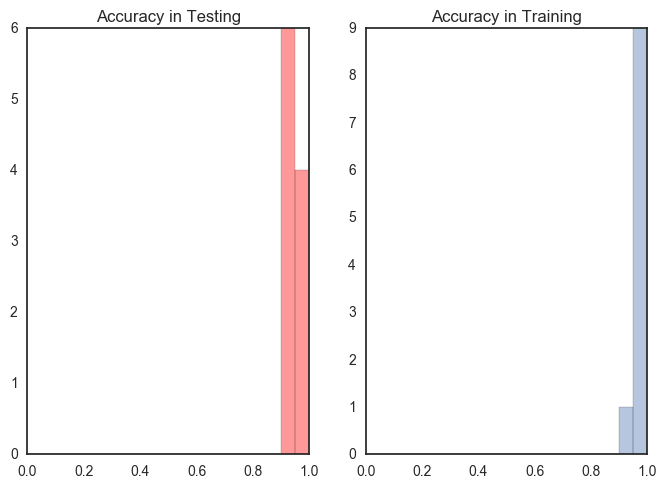

In [34]:
n_split_train = dataTrain.shape[0]/obs_fold
n_split_test = dataTest.shape[0]/ obs_fold
clf1 = linearModel.LogisticRegression(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf1)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

# Support Vector Machine

Training...
Testing...


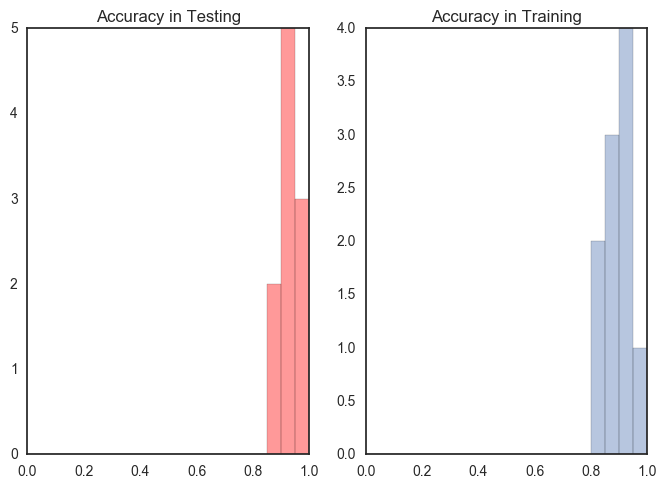

In [46]:
clf2 = svm.SVC(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


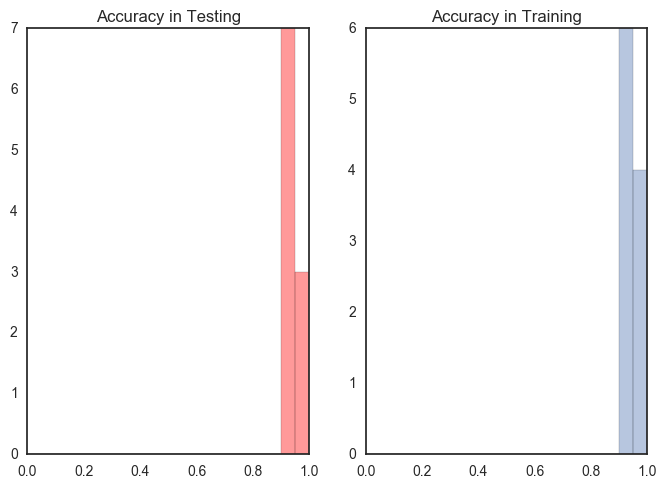

In [47]:
clf2 = svm.SVC(C=2.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


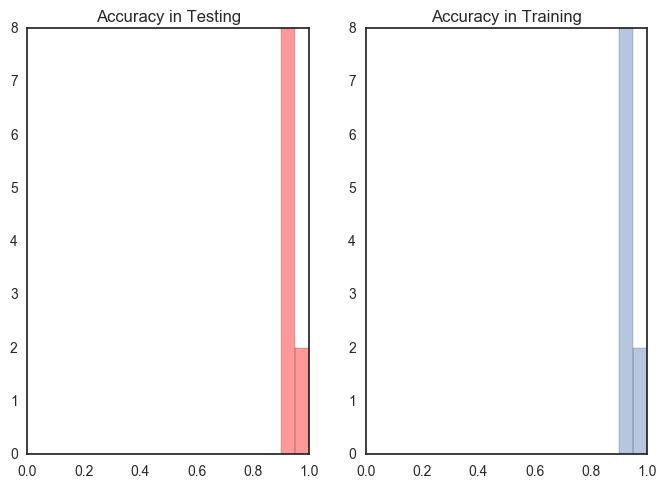

In [49]:
clf2 = svm.SVC(C=16.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


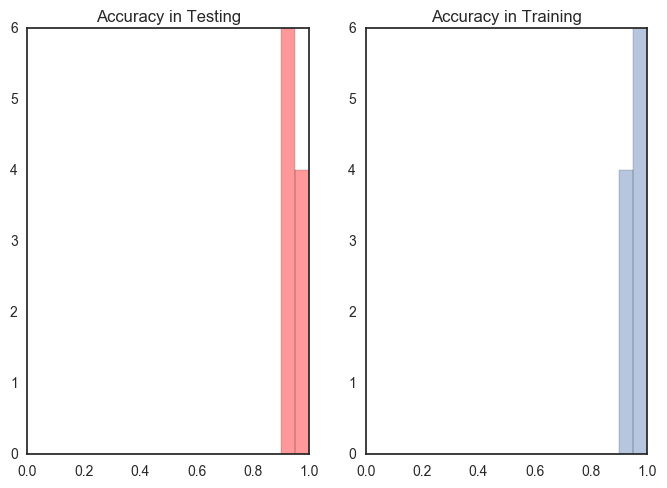

In [52]:
clf2 = svm.SVC(C=128.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

# What if we increase the hyperparameter "max depth"

Training...
Testing...


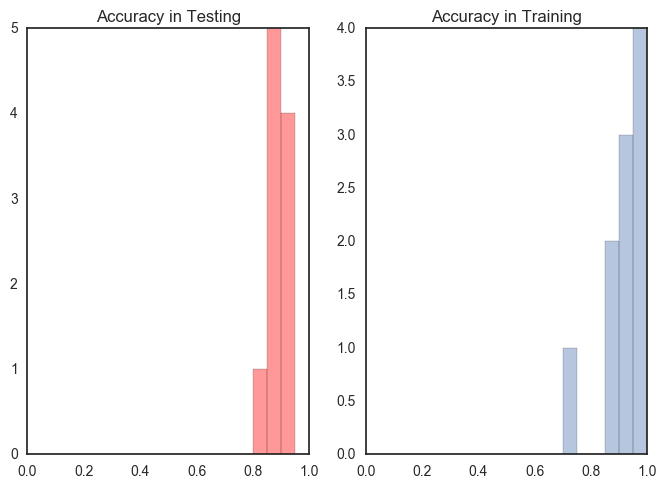

In [45]:
clf3 = RandomForestClassifier(max_depth=2, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


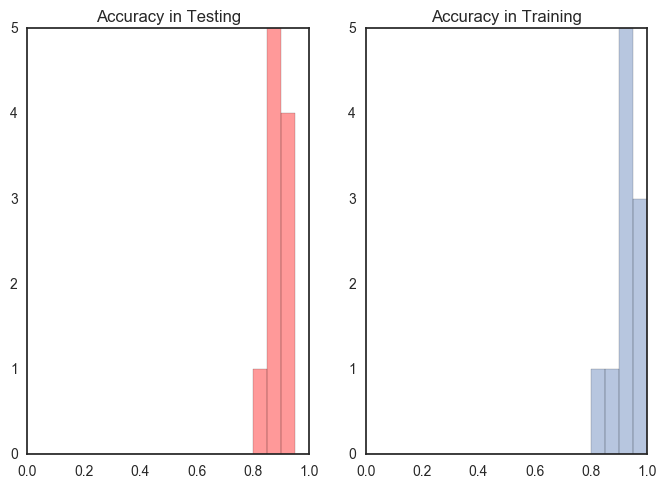

In [37]:
clf3 = RandomForestClassifier(max_depth=3, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


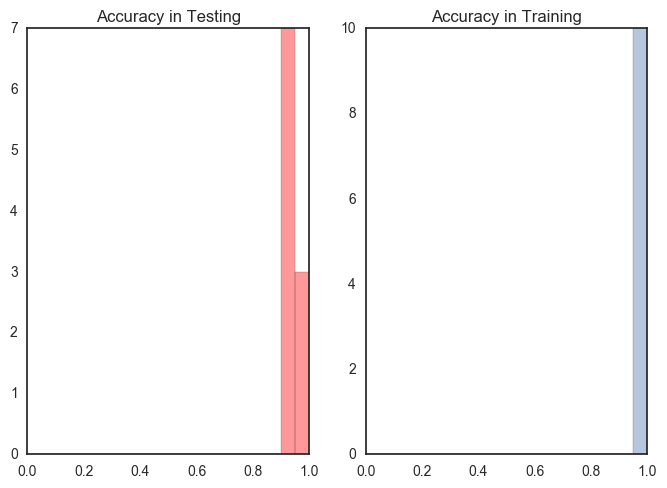

In [39]:
clf3 = RandomForestClassifier(max_depth=4, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


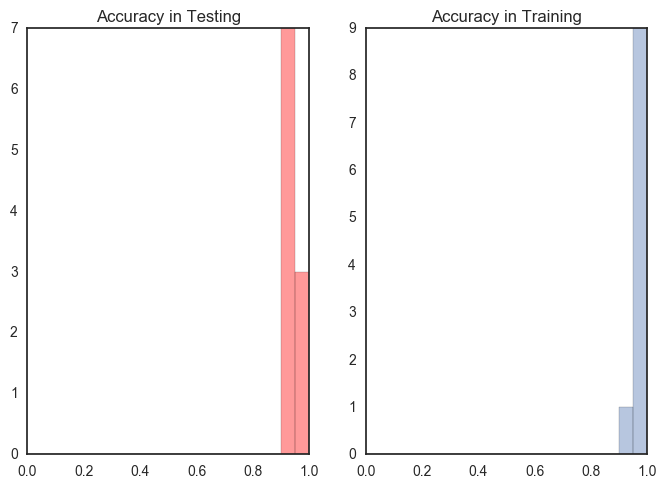

In [40]:
clf3 = RandomForestClassifier(max_depth=5, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


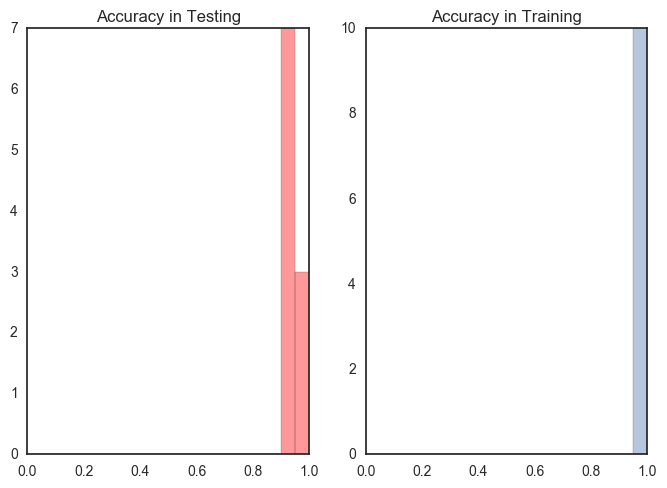

In [41]:
clf3 = RandomForestClassifier(max_depth=6, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


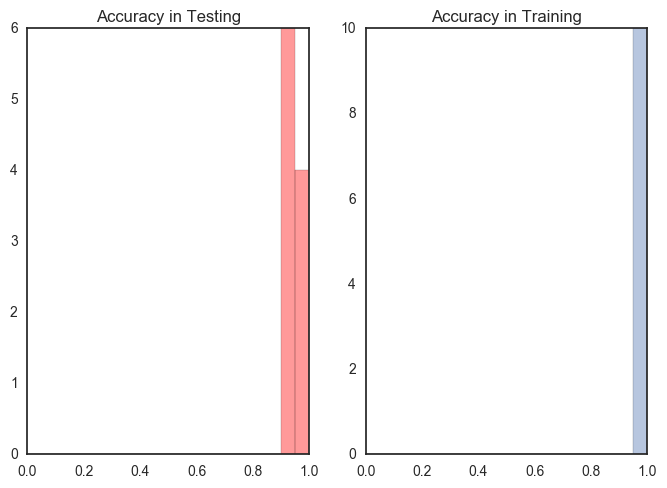

In [42]:
clf3 = RandomForestClassifier(max_depth=7, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


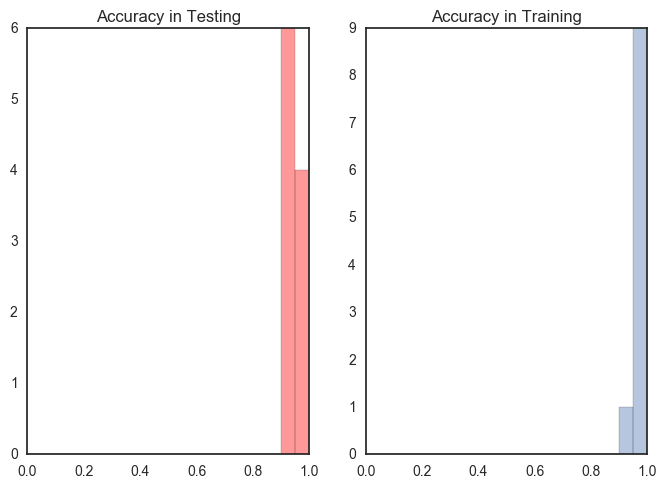

In [43]:
clf3 = RandomForestClassifier(max_depth=8, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


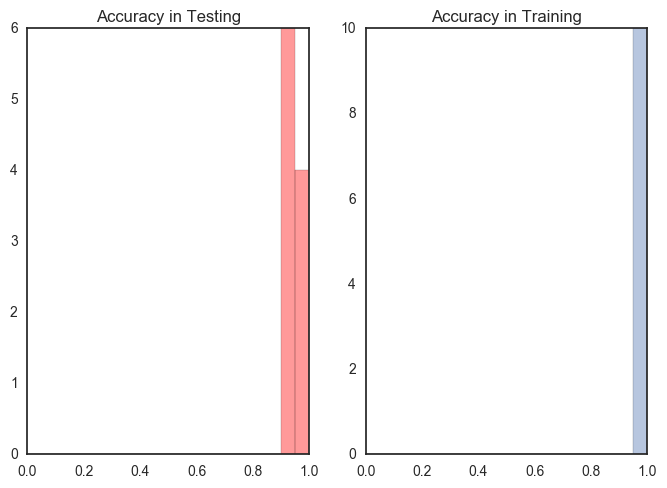

In [44]:
clf3 = RandomForestClassifier(max_depth=15, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

# To DO

use posterior samples from Variational Inference in order to estimate the marginal likelihood...  